## Travel time to regional hubs
Use Mapbox API to calcuate travel time to major neighboring cities (population greater than 1mil).  
Use district centroids as origins

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from infrasap import mapbox_helper as mb
from shapely.wkt import loads

from dotenv import load_dotenv, find_dotenv

%load_ext autoreload
%autoreload 2

In [2]:
country = 'iraq'
iso3 = 'IRQ'
epsg = 32638

In [3]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
mb_token = os.environ.get("MB_TOKEN")

### Load data

In [17]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
# base_in = "/home/wb514197/data/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports_intl.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")

# base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
# out_folder = os.path.join(base_out, iso3)
# if not os.path.exists(out_folder):
#     os.makedirs(out_folder)

out_folder = os.path.join(in_folder, "output")

# global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
global_cities = '/home/public/Data/GLOBAL/Population/global_settlement_points_v1_01_gt50000.shp'

In [18]:
target = gpd.read_file(focal_admin2)
target['centroid'] = target.centroid
cities = gpd.read_file(global_cities)

In [19]:
cities.columns

Index(['OBJECTID', 'UNSD', 'Latlongid', 'Latitude', 'Longitude', 'Pop', 'Year',
       'Urborrur', 'Schnm', 'Name1', 'Name2', 'Name3', 'Forgnnm', 'Schadmnm',
       'Admnm1', 'Admnm2', 'Type', 'Srctyp', 'Coordsrce', 'Datsrc',
       'Locndatsrc', 'Notes', 'Post_Hoc', 'Intentiona', 'ISO3', 'ES90POP',
       'ES95POP', 'ES00POP', 'INSGRUSED', 'Continent', 'Country', 'geometry'],
      dtype='object')

In [21]:
cities_filter = cities.copy()
cities_filter = cities_filter[cities_filter.Pop>1000000].copy() # used to be 1 million, but that's not working for CR

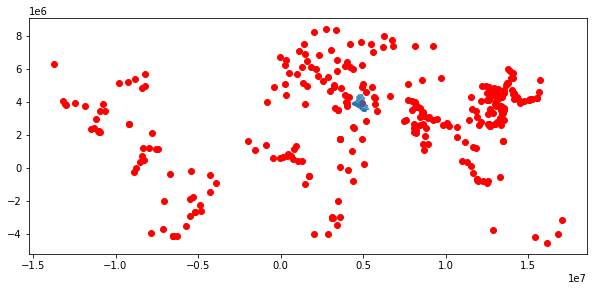

In [22]:
cities_filter = cities_filter.to_crs('EPSG:3857')
target = target.to_crs('EPSG:3857')

ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(7, 7), ax=ax)

In [23]:
# remove cities that are in the country of interest
adm0 = target.dissolve(by='WB_ADM0_CO')
cities_filter = cities_filter.loc[~cities_filter.intersects(adm0.geometry.iloc[0])]

# sort by distance to country
cities_filter['dist_to_ADM0'] = cities_filter.distance(adm0.centroid.iloc[0])
cities_filter = cities_filter.sort_values('dist_to_ADM0')

In [24]:
# choose destinations based on the nearest N cities. 
# N might change depending on the country, if the cities are too far apart use 5, otherwise the Mapbox requests will break
# If there are many cities close by, use 10
n_nearest = 10
cities_filter = cities_filter.head(n_nearest).to_crs(cities.crs)
target = target.to_crs(cities.crs)
target.crs == cities_filter.crs

True

In [25]:
len(cities_filter)

10

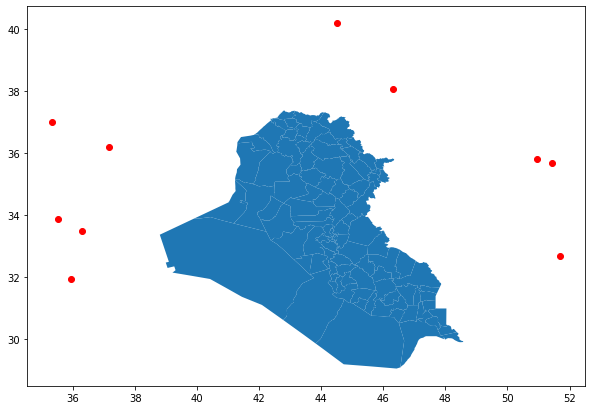

In [26]:
ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(7, 7), ax=ax)

In [27]:
out_folder

'/home/public/Data/PROJECTS/INFRA_SAP/IRQ/output'

In [29]:
cities_filter.Name1

4606     Tabriz
5735    Dimashq
5730      ?alab
4541      Karaj
4525    Esfahan
4665      Amman
4608     Tehran
5276     Bayrut
1138     Erevan
5817      Adana
Name: Name1, dtype: object

In [30]:
cities_filter.to_file(os.path.join('/home/wb514197/data/INFRA_SAP/IRQ', "regional_hubs.shp"), driver="ESRI Shapefile")
# cities_filter.to_file(os.path.join(out_folder, "regional_hubs.shp"), driver="ESRI Shapefile")

In [15]:
origins = target.copy()
dests = cities_filter.copy().reset_index(drop=True)

In [16]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

dests['x'] = dests.geometry.x
dests['y'] = dests.geometry.y

origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

origins['Pop'] = 1
dests['Pop'] = 1

In [17]:
odRes = mb.CreateODMatrix(origins, dests, lat_name = 'y', lon_name = 'x', UID = 'ID',
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = mb_token,
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Mon Nov 23 13:38:15 2020
source list: 11
sources list: 1
dest list: 10
dests list: 1

Estimated remaining calls to chosen server: 1

save points will occur every 1 calls

Call to OSRM server number: 1 of 1


In [18]:
odRes.head()

,D_UID,O_UID,DIST,O_POP,D_POP
0,0,14067,367017.5,1,1
1,1,14067,325926.2,1,1
2,2,14067,53908.9,1,1
3,3,14067,134722.1,1,1
4,4,14067,273151.7,1,1


In [19]:
OD_re = odRes.pivot(index='O_UID',columns='D_UID', values='DIST')
OD_re2 = OD_re.apply(lambda x: x/(60*60))

In [20]:
OD_re2.head()

D_UID,0,1,2,3,4,5,6,7,8,9
O_UID,,,,,,,,,,
14067,101.949306,90.535056,14.974694,37.422806,75.875472,74.924194,74.340306,33.491417,33.808083,34.008167
14068,101.404056,89.989806,15.599111,39.003139,75.330222,74.378944,73.795056,32.946167,33.262833,33.462917
14069,100.241917,88.827667,14.498056,36.946167,74.168083,73.216806,72.632917,31.784028,32.100694,32.300778
14070,98.648139,87.233889,12.843194,38.641583,72.574306,71.623028,71.039139,30.190250,30.506917,30.707000
14071,102.252583,90.838333,15.858639,38.306750,76.178750,75.227472,74.643583,33.794694,34.111361,34.311444


In [21]:
# get the min
OD_re3 = pd.DataFrame(OD_re2.idxmin(axis=1), columns=['ID']).join(pd.DataFrame(OD_re2.min(axis=1), columns=['tt_regional']))
# OD_re3 = pd.DataFrame(data=[OD_re2.idxmin(axis=1), OD_re2.min(axis=1)], index=['D_UID','time']).transpose()

In [22]:
OD_re3.head()

,ID,tt_regional
O_UID,,
14067,2,14.974694
14068,2,15.599111
14069,2,14.498056
14070,2,12.843194
14071,2,15.858639


In [23]:
OD_re3['OBJECTID'] = OD_re3.index.astype('int')
target_hubs = target.merge(OD_re3, on='OBJECTID')

Merge back destination hub name

In [24]:
target_hubs['ID'] = target_hubs['ID'].astype('int')

In [25]:
target_hubs2 = target_hubs.merge(dests[['Name1','ID']], on='ID') # for LAC cities file change to Name / global file Name1
target_hubs2['Name1'].value_counts()

Addis Ababa    11
Name: Name1, dtype: int64

In [26]:
target_hubs2.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [27]:
target_hubs2.rename(columns={'tt_regional':'Time (hrs)', 'ID':'Regional Hub ID', 'Name':'Regional Hub Name'}, inplace=True)

In [28]:
output_path = os.path.join(out_folder, 'tables')
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [29]:
target_hubs2.to_excel(os.path.join(output_path, "8Travel Time to Regional Hub.xlsx"), index=False)